In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data, truncate_data
from matplotlib.ticker import MultipleLocator

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "total_precipitation"
date_range = ["1940-01-01", "2100-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

{'variable': ['total_precipitation'], 'date': ['1940-01-01/2100-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
total_precipitation_1940-01-01_2100-12-31_50.86_4.35.nc


2024-12-10 15:27:15,999 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-10 15:27:15,999 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-10 15:27:16,000 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-10 15:27:16,000 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.
2024-12-10 15:27:16,400 INFO Request ID is 2dde1cc7-ad5c-466f-a45c-5c

Retrieving data in to:  total_precipitation_1940-01-01_2100-12-31_50.86_4.35.nc


In [2]:
# Make a function to compute the annual mean precipitation time series
def precipAnnualTimeseries():
    """
    Processes the annual timeseries of precipitation data.
    This function reads precipitation data from a NetCDF file, removes data for the incomplete current year,
    resamples the data to annual sums, and converts the values to millimeters.
    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): An array of years corresponding to the annual precipitation sums.
            - values (numpy.ndarray): An array of annual precipitation sums in millimeters.
    """

    data = xr.open_dataset(data_file)
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(valid_time="YE").sum() * 1000
    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    return (years, values)

years1, ts1 = precipAnnualTimeseries()

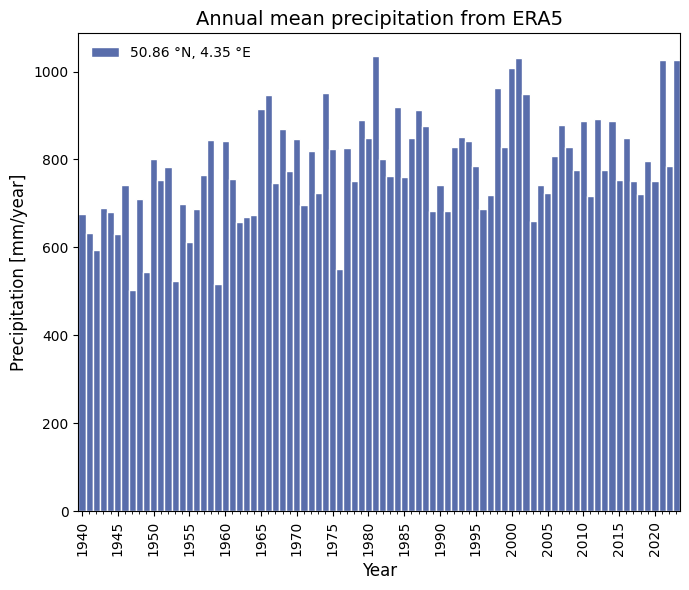

In [3]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

# Create a new figure
plt.figure(figsize=(7, 6))

# Plot the data as a bar chart
plt.bar(
    years1,
    ts1,
    width=1,
    color='#596DAB',
    label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}',
    edgecolor='white',
)
# Add legend
plt.legend(framealpha=0)

# Set x-ticks to appear every 10 years and rotate them
plt.xticks(np.arange(1940, 2100, 5), rotation=90)
plt.xlim(years1[0] - 0.5, years1[-1] + 0.5)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every 1 year

# Customize x and y axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Precipitation [mm/year]', fontsize=12)

# Add title with custom font
plt.title('Annual mean precipitation from {:s}'.format(ERA_VERSION), fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()